In [7]:
# TODO 
# for reprociblity set random seed -- it should be the last two digits of your student ID 

### Text Modality: Clinical Notes Specialty Classification

#### Objective
In this homework, you will build and evaluate models that classify **clinical notes** into **medical specialties**. This task is important for organizing medical records and for clinical decision support (e.g., routing patients to the right clinic).  

We will start from simple baselines and gradually move toward more advanced text representation methods.


#### Deliverables

-   A **clean Jupyter Notebook** with:
    -   Code cells (organized with headers), create cells whenever needed. 
    -   Outputs (EDA figures, evaluation reports, confusion matrices).
    -   Written answers to all reflection/discussion questions, create cells whenver needed (in markdown cells). 

### First Step

We will use the Hugging Face dataset **`harishnair04/mtsamples`**.  
- **Input:** `transcription` column (free-text note).  
- **Target:** `medical_specialty` column (categorical label).  

Download and load the dataset using the code below 


In [3]:
from datasets import load_dataset

dataset = load_dataset("harishnair04/mtsamples")

### Exploring the Data (10 pts)


1. Display a few corresponding input & output samples 

In [5]:
import pandas as pd

data = dataset["train"].to_pandas()
data = data.drop(["Unnamed: 0"], axis = 1)
data.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


2. Explain what input & ouput samples represent? 

The input samples (transcription) represents the clinal notes of patients describing their health condition and past medical history. The output samples (medical_specality) represents the clinical decision to help route patients to the right clinic.

3. Report class distribution and discuss imbalance (e.g., using countplot). 

The below graph shows the class distribution of the medical_specality column. There is a large class imbalance among the samples as there are more samples beloging to the "Surgery" class compared to all other medical specalities. This could lead to the model being baised toward the "Surgery" class.

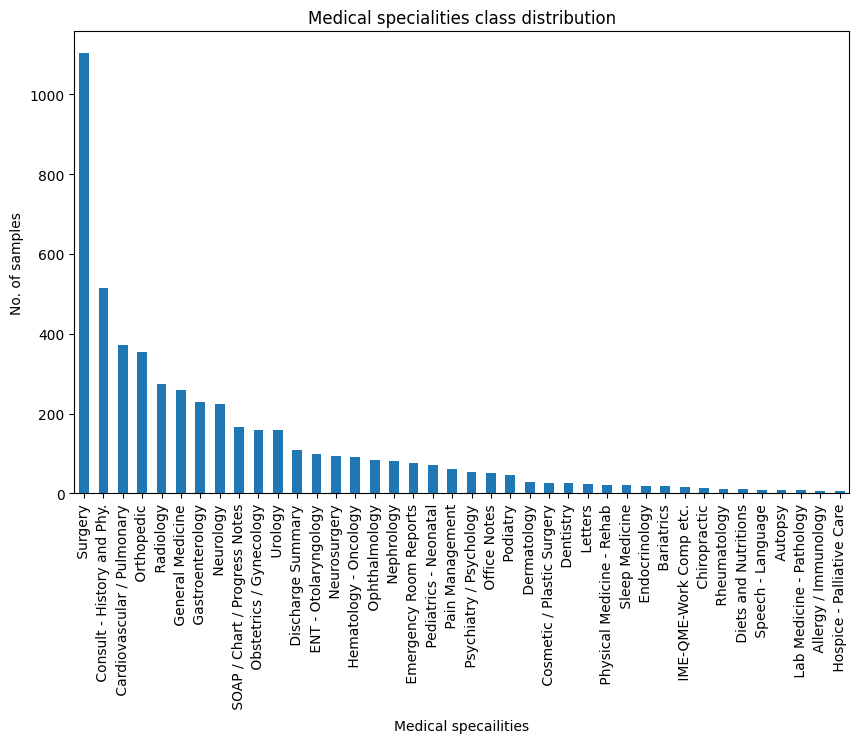

In [7]:
import matplotlib.pyplot as plt

ls = data["medical_specialty"].value_counts()

ls.plot(kind = "bar", figsize = (10, 6))
plt.xlabel("Medical specailities")
plt.ylabel("No. of samples")
plt.title("Medical specialities class distribution")
plt.show()

#### Preprocessing (10 pts)

1. Check if preprocessing is necessary for this data (e.g., lowercasing, whitespace normalization, ...)
2. Split into train/test (e.g., 80/20), stratified by specialty.
   - For hyper-parameter tuning use 10% of training data as validation set. 

In [9]:
data.isnull().sum()

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [11]:
data = data.dropna(subset = ["transcription"])

In [13]:
def preprocess_text(text):
    text = text.lower().strip()
    text = " ".join(text.split())
    return text

data["transcription"] = data["transcription"].apply(preprocess_text)

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["label"] = le.fit_transform(data["medical_specialty"])

In [17]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size = 0.2, stratify = data["label"], random_state = 74)

In [19]:
train_data, val_data = train_test_split(train_data, test_size = 0.1, stratify = train_data["label"], random_state = 74)

### Classification Experiments (Total 60 pts)

We will conduct **stepwise experiments**, starting from baseline models toward more advanced methods.


### Experimental Design

### 1. Evaluation:
  -  Classification_report
  -  Confusion matrix plot   
  -  Perform **error analysis**: show a few false positives and false negatives, and explain possible reasons.

### 2. Methods

#### 2.1. Word-Level Tokenizer + BiLSTM (30 pts)

Please refer to this blog to read more about LSTM: [Link](https://www.scaler.com/topics/pytorch/lstm-pytorch/)  
- Tokenize text with **Keras / Torch word-level Tokenizer**.   
- Train a **BiLSTM model** with an embedding layer (initialized randomly), dropout, and dense layers.    


#### 2.2. Pretrained Embeddings (Word2Vec / GloVe / FastText) + BiLSTM (30 pts)
Please refer to this blog to read more abouot pretrained word embeddings: [link](https://medium.com/@mervebdurna/advanced-word-embeddings-word2vec-glove-and-fasttext-26e546ffedbd) 

- In this part, let's use  pretrained vectors. Instead of random embeddings, use pretrained vectors generted using one of the following methods:  
  - **GloVe**   
  - **Word2Vec**   
  - **FastText**
  
- Build an **embedding matrix** aligned with your tokenizer’s vocabulary and initialize the `Embedding` layer with it. 
- Use the same architecture as the previuos architecture.







#### Word-Level Tokenizer + BiLSTM 

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

MAX_WORDS = 20000
MAX_LEN = 300
 
tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_data["transcription"])

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["transcription"]), maxlen = MAX_LEN, padding = "post")
X_val   = pad_sequences(tokenizer.texts_to_sequences(val_data["transcription"]), maxlen = MAX_LEN, padding = "post")
X_test  = pad_sequences(tokenizer.texts_to_sequences(test_data["transcription"]), maxlen = MAX_LEN, padding = "post")

le = LabelEncoder()
y_train = le.fit_transform(train_data["medical_specialty"])
y_val   = le.transform(val_data["medical_specialty"])
y_test  = le.transform(test_data["medical_specialty"])

num_classes = len(le.classes_)

EMBEDDING_DIM = 128

model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = EMBEDDING_DIM, input_length = MAX_LEN),
    Bidirectional(LSTM(128, return_sequences = False)),
    Dropout(0.5),
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(num_classes, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model.build(input_shape = (None, MAX_LEN))

model.summary()

C:\Users\Anjana\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 300, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,861,224 (10.91 MB)

 Trainable params: 2,861,224 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, batch_size = 64)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.1954 - loss: 3.3584 - val_accuracy: 0.2638 - val_loss: 2.8220
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.3058 - loss: 2.7846 - val_accuracy: 0.3090 - val_loss: 2.6889
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3217 - loss: 2.6504 - val_accuracy: 0.3141 - val_loss: 2.6238
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3336 - loss: 2.5511 - val_accuracy: 0.3216 - val_loss: 2.6312
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3680 - loss: 2.3773 - val_accuracy: 0.3090 - val_loss: 2.6618
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.3787 - loss: 2.2653 - val_accuracy: 0.2864 - val_loss: 2.7112
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.3822 - loss: 2.1289 - val_accuracy: 0.2588 - val_loss: 2.7831
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4009 - loss: 2.0295 - val_accuracy: 0.2663 - v

#### Evaluation:

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step
Classification Report:
                                 precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         1
                       Autopsy       0.00      0.00      0.00         1
                    Bariatrics       0.00      0.00      0.00         4
    Cardiovascular / Pulmonary       0.10      0.07      0.08        74
                  Chiropractic       0.00      0.00      0.00         3
    Consult - History and Phy.       0.08      0.09      0.08       103
    Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                     Dentistry       0.00      0.00      0.00         5
                   Dermatology       0.00      0.00      0.00         6
          Diets and Nutritions       0.00      0.00      0.00         2
             Discharge Summary       0.00      0.00      0.00        22
          ENT - Otolaryngology       0.07      0.05      0.06        1

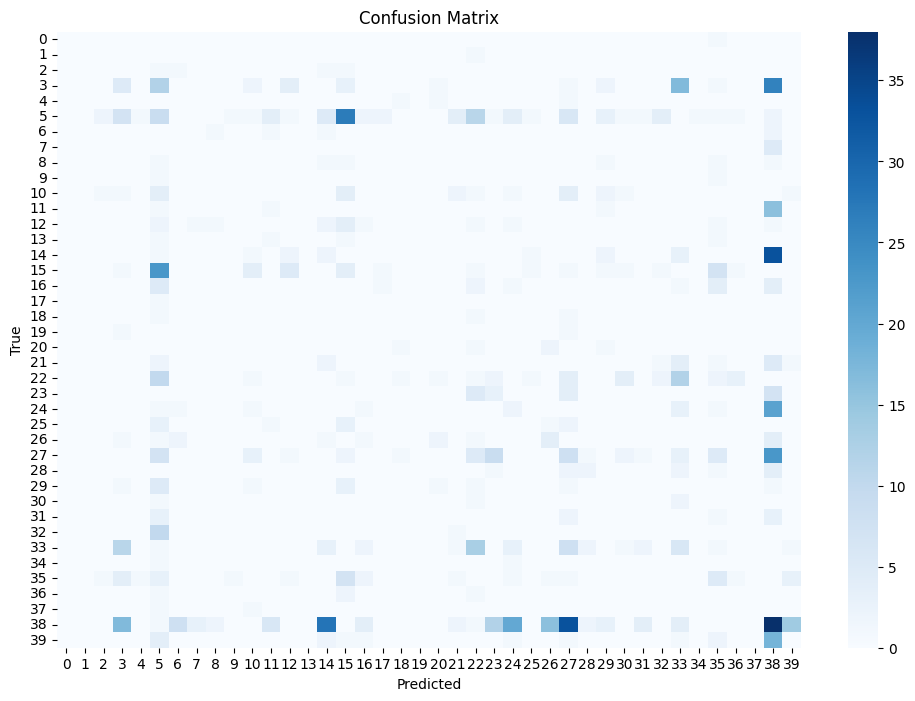

In [30]:
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels, zero_division = 0))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot = False, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Pretrained Embeddings (Word2Vec / GloVe / FastText) + BiLSTM

In [32]:
from gensim.models import Word2Vec

MAX_WORDS = 20000
MAX_LEN = 300
EMBEDDING_DIM = 100

sentences = [text.split() for text in train_data["transcription"]]
w2v_model = Word2Vec(sentences, vector_size = EMBEDDING_DIM, window = 5, min_count = 2, workers = 4)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

model = Sequential([
    Embedding(
        input_dim = vocab_size,
        output_dim = EMBEDDING_DIM,
        weights = [embedding_matrix],
        input_length = MAX_LEN,
        trainable = False
    ),
    Bidirectional(LSTM(128, return_sequences = False)),
    Dropout(0.5),
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(len(le.classes_), activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model.build(input_shape = (None, MAX_LEN))

model.summary()

C:\Users\Anjana\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 300, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,552 (8.67 MB)

 Trainable params: 272,552 (1.04 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [34]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, batch_size = 64)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 888ms/step - accuracy: 0.1963 - loss: 3.2113 - val_accuracy: 0.3141 - val_loss: 2.6436
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 865ms/step - accuracy: 0.3135 - loss: 2.6500 - val_accuracy: 0.2889 - val_loss: 2.6802
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 878ms/step - accuracy: 0.3213 - loss: 2.5657 - val_accuracy: 0.3342 - val_loss: 2.5265
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 877ms/step - accuracy: 0.3425 - loss: 2.4775 - val_accuracy: 0.3266 - val_loss: 2.4849
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 883ms/step - accuracy: 0.3235 - loss: 2.4094 - val_accuracy: 0.3291 - val_loss: 2.4542
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 879ms/step - accuracy: 0.3476 - loss: 2.3310 - val_accuracy: 0.3116 - val_loss: 2.4735
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 899ms/step - accuracy: 0.3487 - loss: 2.2990 - val_accuracy: 0.3266 - val_loss: 2.3970
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 905ms/step - accuracy: 0.3453 - loss: 2.2320 - val_accu

#### Evaluation:

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step
Classification Report:
                                 precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         1
                       Autopsy       0.00      0.00      0.00         1
                    Bariatrics       0.00      0.00      0.00         4
    Cardiovascular / Pulmonary       0.16      0.12      0.14        74
                  Chiropractic       0.00      0.00      0.00         3
    Consult - History and Phy.       0.12      0.15      0.13       103
    Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                     Dentistry       0.00      0.00      0.00         5
                   Dermatology       0.00      0.00      0.00         6
          Diets and Nutritions       0.00      0.00      0.00         2
             Discharge Summary       0.11      0.09      0.10        22
          ENT - Otolaryngology       0.06      0.05      0.06        1

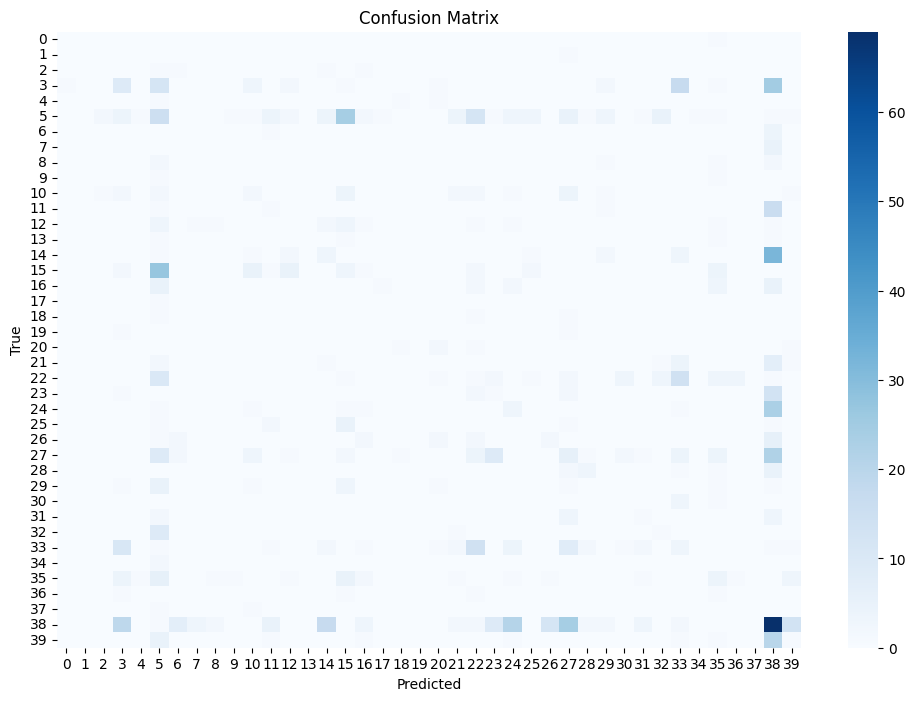

In [36]:
y_pred = np.argmax(model.predict(X_test), axis=1)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels, zero_division = 0))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot = False, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Discussion (20 pts)

After completing experiments, answer:

1. Compare results of both impolementations:   
     - Does pretrained initialization improve performance or convergence?  
2.  What are other better options to improve the performance? 
      - Without implementation, discuss from a high level perspective what are more advanced appraoches that might lead to better results. 

The pretrained initialization with Word2Vec embeddings improved the model's performance and accuracy. The pretrained initialization provided better semantic representations of the clinical terms allowing the model to generalize better for the given data. The model's performance can be improved further using domain-specific embeddings such as BioWordVec or ClinicalBERT, applying attention mechanisms, performing hyperparameter tuning, or data augmentation to reduce the class imbalance. Transformer-based models such as BERT and BioClinicalBERT can capture meaningful patterns in the clinical notes and perform better on these tasks.